# U-Net

## 학습목표
> PASCAL VOC 데이터셋은 Image recognition과 관련된 테스크인 classification, detection, segmentation 등에서 모델간의 성능 비교를 하는 대회를 위해 만들어진 데이터셋이다.\
> 이번 실습에서는 UNet을 직접 구현해보고, PASCAL VOC 데이터를 이용하여 segmentation 테스크를 수행하기 위한 U-Net을 학습 및 테스트한다.


**목차(context)**
> 1. U-Net 모델 설명
> 2. U-Net 모델 구현
> 3. VOC 데이터셋 소개
> 4. VOC 데이터셋 다운로드
> 5. U-Net 모델 학습 및 평가

## U-Net 모델 설명

> U-Net은 image segmentation을 위해 제안된 CNN 모델이다. \
> U-Net은 encoder와 decoder로 구성되어 있는데, 그 모습이 U자와 유사하게 생겼다 하여 U-Net이라고 불린다. \
> Encoder는 물체의 모양과 같은 high-level feature를 추출하는 역할을 한다. \
> Decoder는 이렇게 추출된 feature와 residual connection을 통해 전달되는 encoder 연산 과정 중의 feature를 함께 사용하여 최종 아웃풋을 생성한다. \
> 즉, U-Net 구조는 encoder에서 residual connection을 통해 바로 전달되는 low-level feature와 encoder로부터 추출된 high-level feature를 함께 사용한다. \
> 따라서 U-Net 구조는 이미지의 다양한 레벨의 feature를 추출하여 사용할 수 있게 되며, high-level과 low-level의 feature가 모두 사용되는 segmentation과 같은 테스크에서 특히나 큰 효과를 보인다.

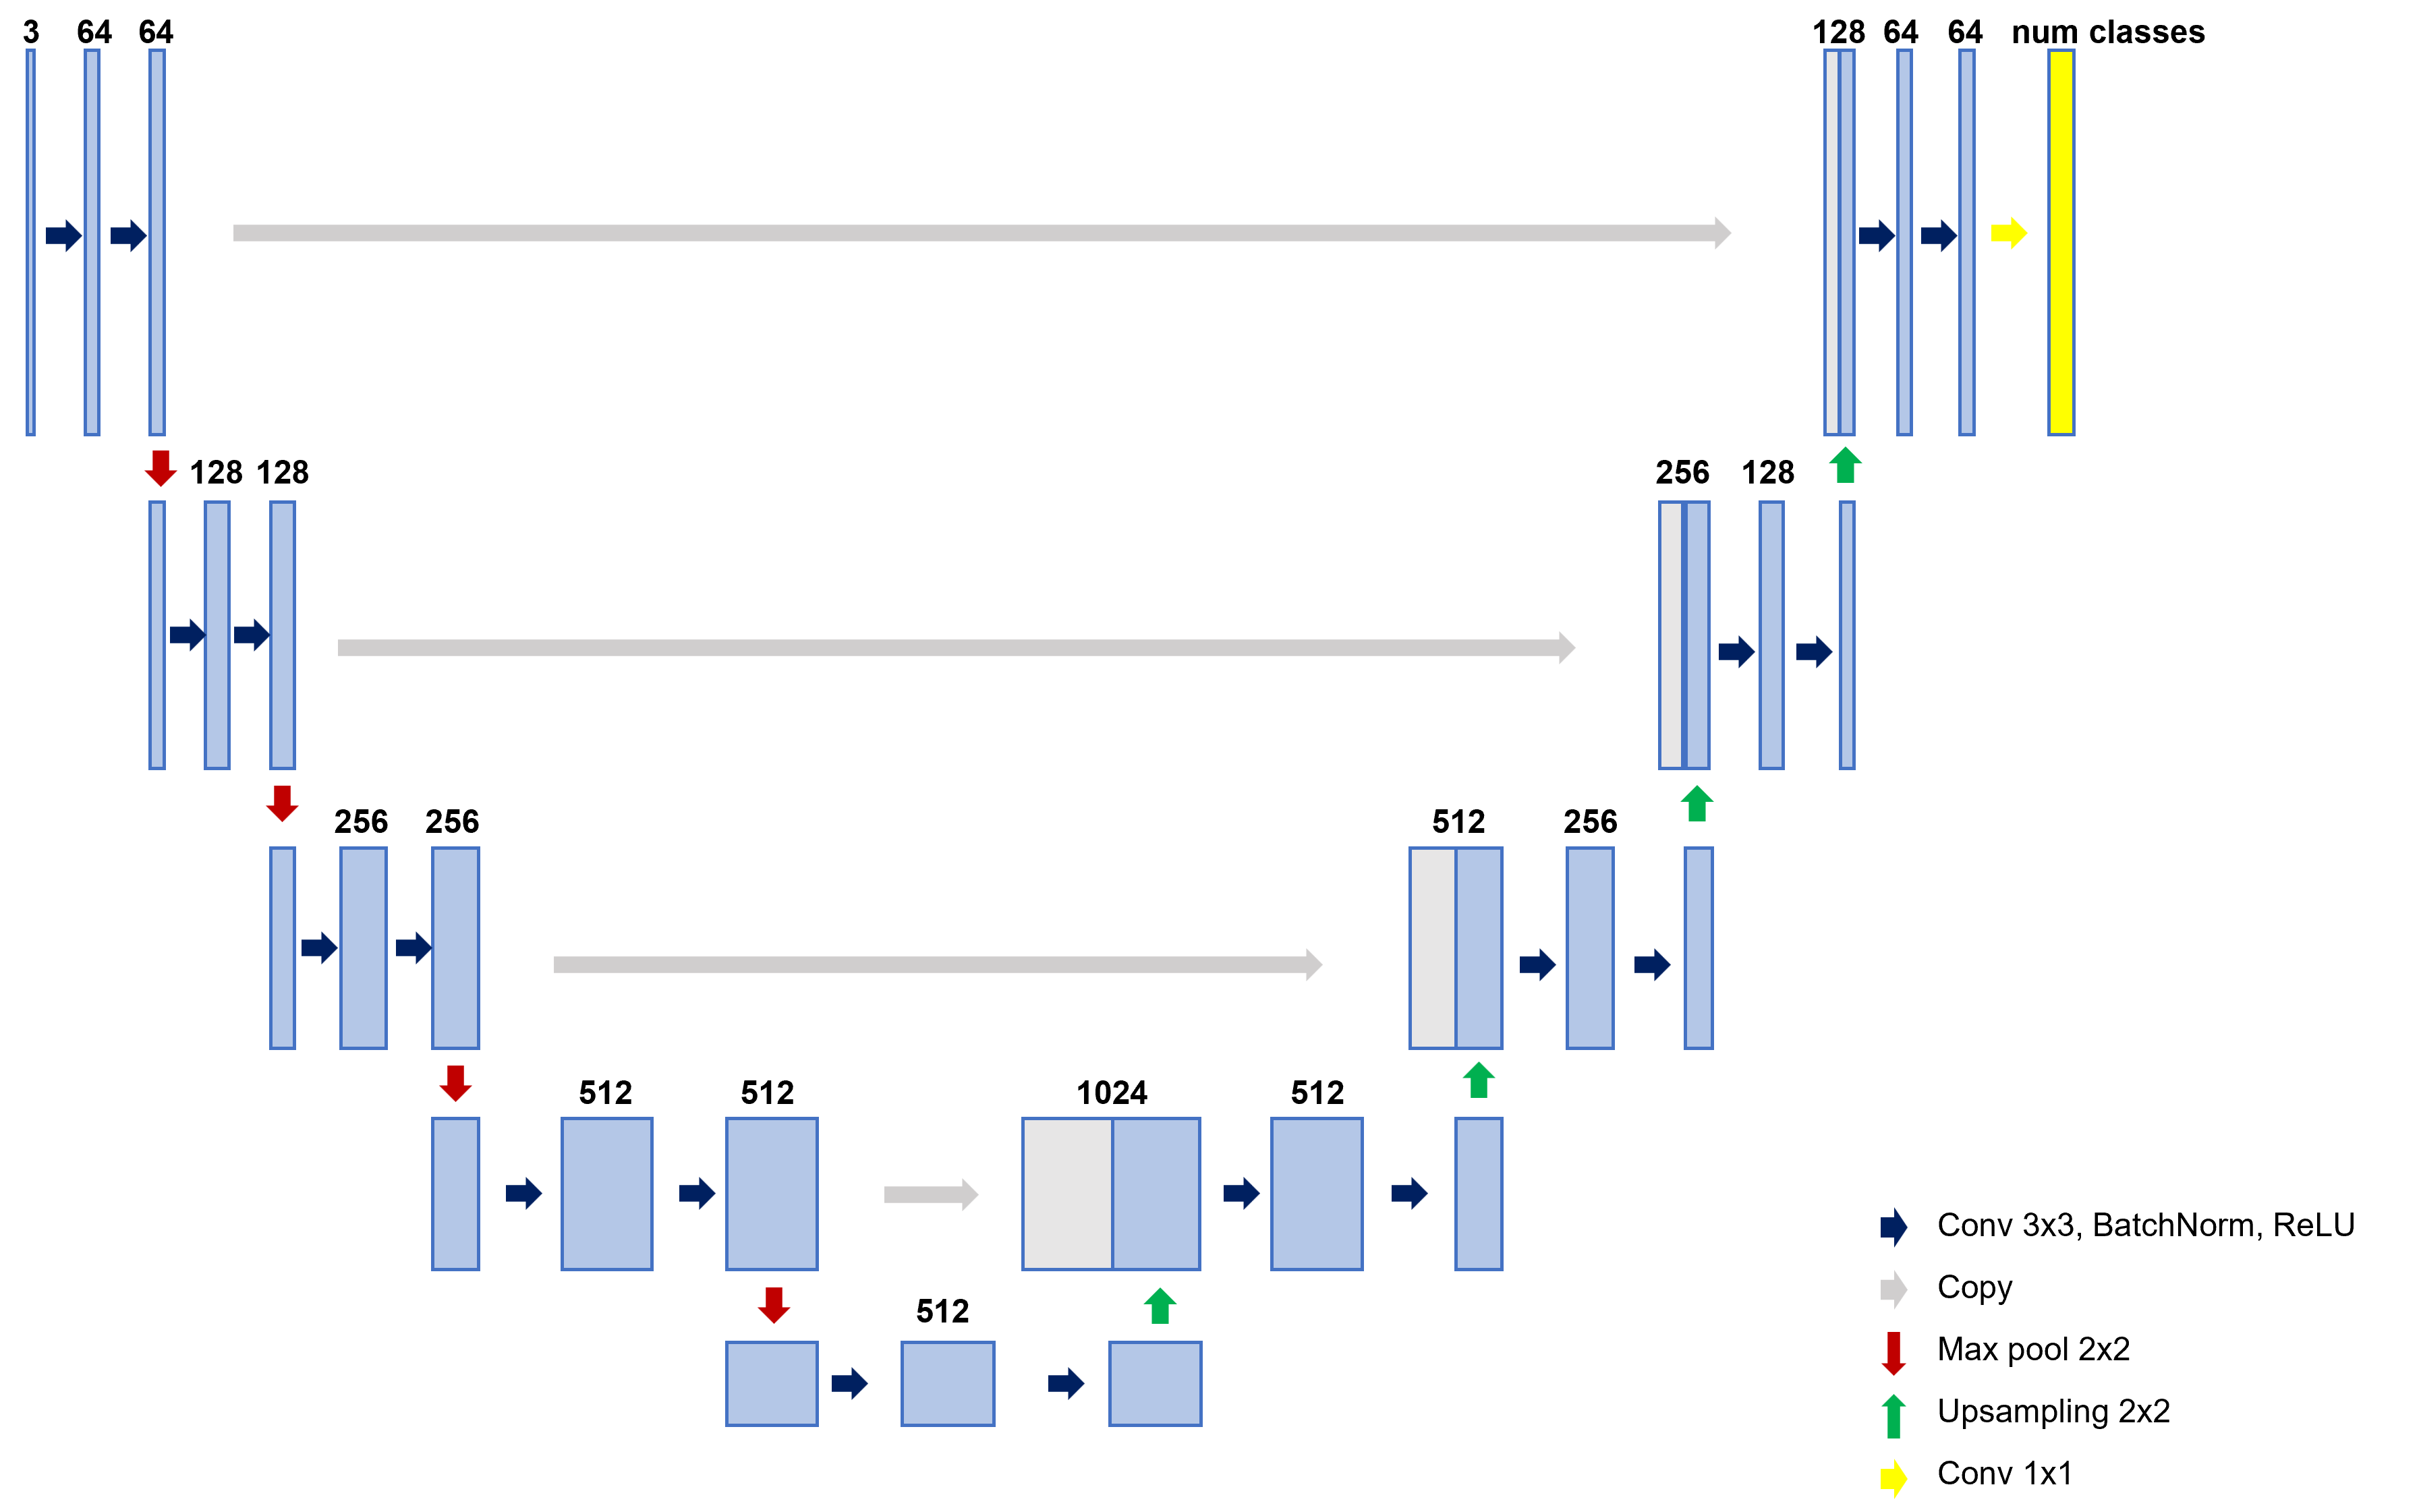

## U-Net 모델 구현

> 그림과 같이 U-Net은 [Conv, BatchNorm, ReLU] 2개로 구성된 있는 블럭을 구현한다. \
> 위 그림처럼 각 블럭은 2개의 컨볼루션 레이어로 이루어져 있다. \
> 따라서 반복되는 블럭의 구현을 효과적으로 하기 위해 ConvBlock layer를 선언한다.

In [ ]:
import torch

import os
import albumentations as A
import numpy as np
import torchvision

from matplotlib import pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torchvision.transforms as T
from torchvision.transforms.functional import to_tensor
from torchvision.utils import save_image
from torchvision.datasets import VOCSegmentation

In [ ]:
class ConvBlock(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if mid_channels is None:
            mid_channels = out_channels

        self.layer = nn.Sequential(
                                    nn.Conv2d(in_channels, mid_channels, 3, 1, 1),
                                    nn.BatchNorm2d(mid_channels),
                                    nn.ReLU(),
                                    nn.Conv2d(mid_channels, out_channels, 3, 1, 1),
                                    nn.BatchNorm2d(out_channels),
                                    nn.ReLU()
                                  )

    def forward(self, x):
        x = self.layer(x)
        return x


> ConvBlock 구현의 검증을 목적으로, 더미 데이터를 만들어서 포워드 연산을 수행해 본다.

In [ ]:
conv_block = ConvBlock(64, 128)
dummy_x = torch.randn([2,64,32,32])
dummy_pred = conv_block(dummy_x)
print(dummy_pred.shape)

torch.Size([2, 128, 32, 32])


> 앞서 만든 ConvBlock을 활용하여, [Downsampling, ConvBlock] 으로 구성된 블럭을 구현한다.

In [ ]:
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.down = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, out_channels)
        )

    def forward(self, x):
        x = self.down(x)
        return x

> Down block 구현의 검증을 목적으로, 더미 데이터를 만들어서 포워드 연산을 수행해 본다.

In [ ]:
down_block = DownBlock(64, 128)
dummy_x = torch.randn([2, 64, 32, 32])
dummy_pred = down_block(dummy_x)
print(dummy_pred.shape)

torch.Size([2, 128, 16, 16])


> 이때 max pooling 연산을 위하여 pytorch에서 제공하는 MaxPool2d라는 함수를 사용한다. \
> 그 사용법은 아래 예시 코드와 같다. \
> 인자(argument) 중 하나인 kernel_size는 pooling을 적용할 window size를 의미하며 stride는 window가 이동할 때의 간격을 의미한다.\
> 만약 stride를 설정해주지 않는다면 default 값으로 kernel_size와 같은 값으로 선언된다.


In [ ]:
m = nn.MaxPool2d(kernel_size=2, stride=2)
input = torch.randn([2,64,32,32])
print('input shape: ', input.shape)
output = m(input)
print('output shape: ', output.shape)

input shape:  torch.Size([2, 64, 32, 32])
output shape:  torch.Size([2, 64, 16, 16])


> 앞서 만든 ConvBlock과 nn.Upsample을 이용해서 [Upsampling, ConvBlock] 으로 구성된 블럭을 구현한다.

In [ ]:
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv = ConvBlock(in_channels, out_channels, in_channels//2)

    def forward(self, x1, x2):
        # Upsampling 통해 spatial resolution 을 2배 키움
        x1 = self.up(x1)
        # skip connection을 통해 들어오는 정보와 이전 layer의 정보를 concat해서 넣어줌
        x = torch.cat((x2, x1), dim=1)
        x = self.conv(x)

        return x

> Up block 구현의 검증을 목적으로, 더미 데이터를 만들어서 포워드 연산을 수행해 본다.

In [ ]:
up_block = UpBlock(128, 64)
dummy_x1 = torch.randn([2,64,32,32])
dummy_x2 = torch.randn([2,64,64,64])
dummy_pred = up_block(dummy_x1, dummy_x2)
print(dummy_pred.shape)

torch.Size([2, 64, 64, 64])


> 마지막 레이어를 구현한다.

In [ ]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

> 앞서 구현한 레이어들을 이용하여 U-Net 모델을 구현한다.

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = ConvBlock(n_channels, 64)

        self.down1 = DownBlock(64, 128)
        self.down2 = DownBlock(128, 256)
        self.down3 = DownBlock(256, 512)
        self.down4 = DownBlock(512, 512)

        self.up1 = UpBlock(1024, 256)
        self.up2 = UpBlock(512, 128)
        self.up3 = UpBlock(256, 64)
        self.up4 = UpBlock(128, 64)
        self.outc = OutConv(64, n_classes)


    def forward(self, x):
        x1 = self.inc(x)

        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        logits = self.outc(x)

        return logits

> U-Net 구현의 검증을 목적으로, 더미 데이터를 만들어서 포워드 연산을 수행해 본다.

In [ ]:
unet = UNet(3, 10)
dummy_x = torch.randn([2,3,32,32])
dummy_pred = unet(dummy_x)
print(dummy_pred.shape)

torch.Size([2, 10, 32, 32])


## VOC 데이터셋 소개
> PASCAL VOC 데이터셋은 Image recognition과 관련된 테스크인 classification, detection, segmentation 등에서 모델간의 성능 비교를 하는 대회를 위해 만들어진 데이터셋이다.\
> 그 중 segmentation과 관련된 데이터셋은 총 20개의 class로 이루어져 있으며 그 종류는 다음과 같다.
> - Person: person
> - Animal: bird, cat, cow, dog, horse, sheep
> - Vehicle: aeroplane, bicycle, boat, bus, car, motorbike, train
> - Indoor: bottle, chair, dining table, potted plant, sofa, tv/monitor
>
> 각 class 별 예시 그림은 아래 그림과 같으며, segmentation task를 진행할 때는 배경도 하나의 class로 포함하여 총 21개의 class를 사용한다. \
> 즉, 우리는 VOC 데이터셋을 이용해 각 pixel 마다 21개의 class 중 하나로 분류하는 task를 수행한다.

![voc](https://drive.google.com/uc?export=download&id=18mfU-4COxtAmhgVzXdYhbkb5vsqH6xM2)

> VOC 데이터셋은 segmentation task의 학습을 위해 아래 그림과 같이 segmentation용 label을 제공한다.

![voc](https://drive.google.com/uc?export=download&id=1WGKRYUyaWx8g8A4ToSMG4p6szouVqSzN)

## VOC 데이터셋 다운로드
> PASCAL VOC 2007 데이터셋을 다운로드한다.

In [ ]:
VOCSegmentation(root='./data', year='2007', download=True)

100%|██████████| 460032000/460032000 [00:17<00:00, 26370831.93it/s]


Extracting ./data/VOCtrainval_06-Nov-2007.tar to ./data


Dataset VOCSegmentation
    Number of datapoints: 209
    Root location: ./data

> 다운로드한 데이터셋을 통해 Dataset 객체를 만든다.

In [ ]:
class DatasetFromFolderVOC(Dataset):
    def __init__(self, root_dir= './data/VOCdevkit/VOC2007', txt_file='train.txt', transforms=None):
        super(DatasetFromFolderVOC, self).__init__()
        with open(os.path.join(root_dir, 'ImageSets/Segmentation', txt_file), 'r') as f:
            self.filenames = f.readlines()
        self.filenames = [file.strip() for file in self.filenames]
        self.img_path = os.path.join(root_dir, "JPEGImages")
        self.gt_path = os.path.join(root_dir, "SegmentationClass")
        self.transforms = transforms
        self.pallete = Image.open(os.path.join(self.gt_path, f'{self.filenames[0]}.png')).getpalette()

    # getitem 함수는 index에 맞는 data를 반환하는 역할을 함
    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_path, f'{self.filenames[index]}.jpg')).convert('RGB')
        gt = Image.open(os.path.join(self.gt_path, f'{self.filenames[index]}.png'))

        aug = self.transforms(image=np.array(img), mask=np.array(gt))
        img = to_tensor(aug['image'])
        gt = aug['mask']
        gt[gt > 20] = 0
        gt = torch.tensor(gt)

        return img, gt

    # len 함수는 Dataset 전체 개수를 반환을 함
    def __len__(self):
        return len(self.filenames)

In [ ]:
transforms = A.Compose([
    A.Resize(512, 512),
    A.RandomCrop(400, 400),
    A.HorizontalFlip(always_apply=True),
    # A.VerticalFlip(always_apply=True),
    A.Resize(512, 512),
])

dataset = DatasetFromFolderVOC(transforms=transforms)

> 불러온 데이터 중 하나를 확인해 본다.

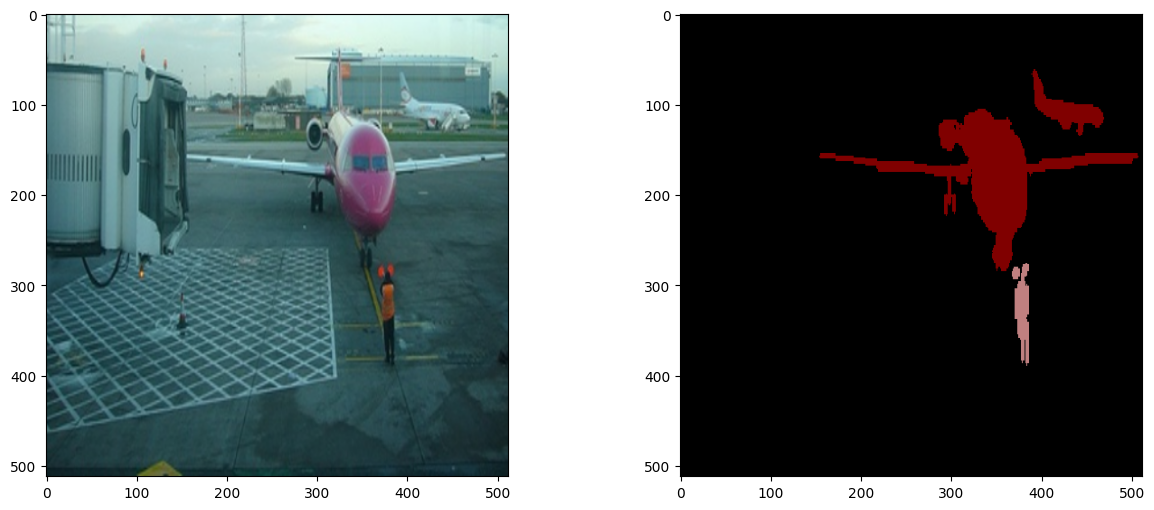

In [ ]:
img, gt = dataset[0]
pallete = dataset.pallete

gt_img = Image.fromarray(np.array(gt))
gt_img.putpalette(dataset.pallete)

# 실제 이미지 와 Ground truth 이미지 시각화
plt.rcParams["figure.figsize"] = (15, 6)
plt.subplot(1, 2, 1)
plt.imshow(img.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(gt_img)

> DataLoader를 선언해 준다.

In [ ]:
train_transforms = A.Compose([
    A.Resize(128, 128),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

test_transforms = A.Compose([
    A.Resize(128, 128),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

trainDataSet = DatasetFromFolderVOC(txt_file='train.txt', transforms=train_transforms)
testDataSet = DatasetFromFolderVOC(txt_file='val.txt', transforms=test_transforms)

# Training Set과 Test Set을 각각 DataLoader에 넣음
trainDataLoader = DataLoader(dataset=trainDataSet, num_workers=1, batch_size=8, shuffle=True, drop_last=True)
testDataLoader = DataLoader(dataset=testDataSet, num_workers=1, batch_size=8, shuffle=False, drop_last=True)

## U-Net 모델 학습 및 평가

> Model을 선언해 준다. 이때, 클래스는 배경까지 포함하여야 하기 때문에 21로 설정한다.

In [ ]:
num_classes = 21  # 20 + 배경
model = UNet(3, num_classes).cuda()
criterion = nn.CrossEntropyLoss()

> 학습에 앞서 세가지의 유용한 함수를 선언해준다.\
> 학습 중간에 loss의 값이 어떻게 변하는지를 시각화 해주는 loss_plot함수를 구현한다.

In [ ]:
def loss_plot(loss):
    plt.plot(loss)
    plt.xlabel('log')
    plt.ylabel('loss')
    plt.grid(True)
    plt.show()
    return 0

> 학습이 시작한 후 시간이 얼마나 흘렀는지를 확인할 수 있는 Timer 클래스를 구현한다.

In [ ]:
import time
class Timer():
    def __init__(self):
        self.cur_t = time.time()

    def tic(self):
        self.cur_t = time.time()

    def toc(self):
        return time.time() - self.cur_t

    def tocStr(self, t=-1):
        if (t == -1):
            return str(datetime.timedelta(seconds=np.round(time.time() - self.cur_t, 3)))[:-4]
        else:
            return str(datetime.timedelta(seconds=np.round(t, 3)))[:-4]

> 테스트 데이터로 모델의 일반화 성능을 측정하기 위한 함수를 구현한다.

In [ ]:
def test_seg(model, loss_list):
    model.eval()
    running_loss = 0.0
    for i, (img, gt) in enumerate(testDataLoader):
        with torch.no_grad():
            # forward
            img = img.cuda()
            gt = gt.long().cuda()
            pred = model(img)
            loss = criterion(pred, gt)
            running_loss += loss

        if (i+1) % 20 == 0:
            print(f'Current test loss: {running_loss.item()/(i+1):.3f}')
    loss_list.append(running_loss.item()/(i+1))
    return loss_list

> Optimizer를 선언한 후 학습을 시작한다.

Epoch [1] train loss: 2.959 iter_time: 1.8664941787719727
Current test loss: 3.102
Epoch [2] train loss: 2.836 iter_time: 4.141009330749512
Current test loss: 2.937
Epoch [3] train loss: 2.766 iter_time: 3.9595487117767334
Current test loss: 2.691
Epoch [4] train loss: 2.654 iter_time: 3.692082405090332
Current test loss: 2.822
Epoch [5] train loss: 2.528 iter_time: 3.66180682182312
Current test loss: 2.559
Epoch [6] train loss: 2.585 iter_time: 4.056276559829712
Current test loss: 2.502
Epoch [7] train loss: 2.360 iter_time: 3.6603903770446777
Current test loss: 2.718
Epoch [8] train loss: 2.572 iter_time: 3.6817288398742676
Current test loss: 2.573
Epoch [9] train loss: 2.577 iter_time: 3.7611289024353027
Current test loss: 3.223
Epoch [10] train loss: 2.382 iter_time: 3.870290756225586
Current test loss: 2.633
Epoch [11] train loss: 2.341 iter_time: 3.7296135425567627
Current test loss: 2.351
Epoch [12] train loss: 2.180 iter_time: 3.7997117042541504
Current test loss: 2.382
Epoch [

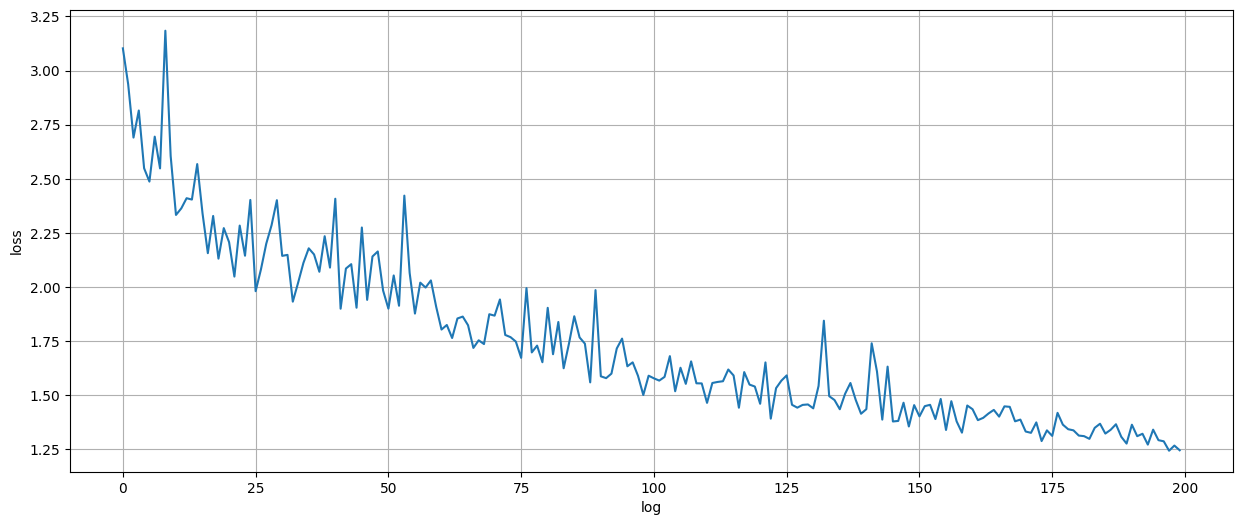

0

In [ ]:
tell_time = Timer()
iter_time = 0

# Optimizer 선언
optimizer = optim.Adam(model.parameters(), lr=1e-5, betas=(0.9, 0.999))
total_epoch = 200

# 모델 학습
loss_list = []
for epoch in range(total_epoch):
    for i, (img, gt) in enumerate(trainDataLoader):
        model.train()
        img = img.cuda()
        gt = gt.long().cuda()

        pred = model(img)
        loss = criterion(pred, gt)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(f'Epoch [{epoch+1}] train loss: {loss.item():.3f} iter_time: {tell_time.toc()-iter_time}')
            iter_time = tell_time.toc()
            loss_list = test_seg(model, loss_list)
loss_plot(loss_list)

> 테스트 데이터를 이용해 학습된 모델을 평가한다.

In [ ]:
model.eval()
running_loss = 0.0
for i, (img, gt) in enumerate(testDataLoader):
    with torch.no_grad():
        # forward
        img = img.cuda()
        gt = gt.long().cuda()
        pred = model(img)
        loss = criterion(pred, gt)
        running_loss += loss

print(f'Test loss: {running_loss.item()/(i+1):.3f}')

Test loss: 1.298
